## Checking the feasibility of the payload

The idea here is to get a sense of what kind of events would be possible to detect by our accelerometer. This model will be a 2D model of 1km x 1km, with the parameters defined as follows.

Velocity of p-wave=3km

Velocity of s_wave=1.5km

Density of the medium(assumed uniform)=2 g/cc

The boundary conditions are as follows:

The top surface has free boundary surface.

The other three surfaces have absorbing boundary conditions(ideally completely).

The impact of the micrometeoroid will be modelled by ricker source(though actually a delta function) which is tuned for the maximum intensity at the frequency of our accelerometer detection.The acceleration is capable of sampling rate from  19.5Hz to 952Hz, but we'll take the middle of capacity which is approximately 500Hz and the more standard 50 HZ also. Also the intensity of the source will be based on the expected force generated by the impact of largest micrometeoroid which we want to analyse.From the payload analysis doc, we have:

time for collision= 1ms

Mass considered=15 micrograms

Velocity=13300km/s

So the average force during the time of impact amounts to approximately 0.2N.

#### NOTE: This notebook largely borrows the boundary conditions as in devito/examples/userapi/boundary_conditions.


In [1]:
#importing files required for processing
import numpy  as np
import matplotlib.pyplot as plt
%matplotlib inline
#for devito we'll import the required functions when the need arises.
from devito import Grid,TimeFunction, VectorTimeFunction, TensorTimeFunction,div, grad, curl, diag,SubDomain
from examples.seismic import Model, plot_velocity, TimeAxis, RickerSource, plot_image,Receiver

In [2]:
# NOw defining the subdoamins and the boundary conditions that will be used using the subdomains
nbpml=10# number of absorbing boundary layers/perfectly matched layers

class MainDomain(SubDomain):  # Main section with no damping
    name = 'main'
    def __init__(self, PMLS):
        super().__init__()
        self.PMLS = PMLS
            

    def define(self, dimensions):
        x, y = dimensions
        return {x: ('middle', self.PMLS, self.PMLS), y: ('middle', 0, self.PMLS)}


class Left(SubDomain):  # Left PML region
    name = 'left'
    def __init__(self, PMLS):
        super().__init__()
        self.PMLS = PMLS

    def define(self, dimensions):
        x, y = dimensions
        return {x: ('left', self.PMLS), y: y}


class Right(SubDomain):  # Right PML region
    name = 'right'
    def __init__(self, PMLS):
        super().__init__()
        self.PMLS = PMLS

    def define(self, dimensions):
        x, y = dimensions
        return {x: ('right', self.PMLS), y: y}
    
    
class Base(SubDomain):  # Base PML region
    name = 'base'
    def __init__(self, PMLS):
        super().__init__()
        self.PMLS = PMLS

    def define(self, dimensions):
        x, y = dimensions
        return {x: ('middle', self.PMLS, self.PMLS), y: ('right', self.PMLS)}


main_domain = MainDomain(nbpml)
left = Left(nbpml)
right = Right(nbpml)
base = Base(nbpml)

Operator `initdamp` run in 0.01 s
Operator `padfunc` run in 0.01 s
Operator `padfunc` run in 0.01 s
Operator `padfunc` run in 0.01 s


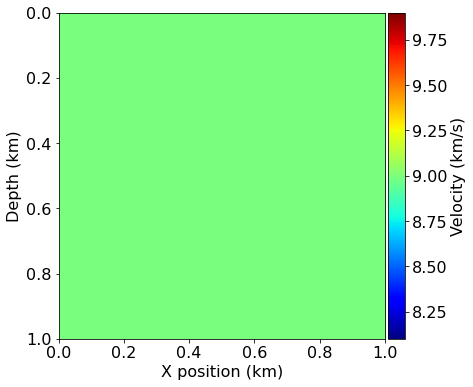

In [3]:

from examples.seismic import Model, plot_velocity

# Define a physical size
shape = (101, 101)  # Number of grid point (nx, nz)
spacing = (10., 10.)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (0., 0.)  # What is the location of the top left corner. This is necessary to define
# the absolute location of the source and receivers

# Define a velocity profile. The velocity is in km/s
# As the initial model is uniform taking
vp=3*np.ones(shape=shape)
vs=1.5*np.ones(shape=shape)# defining constant velocity at each point in domain
density=2*np.ones(shape=shape)

# With the velocity and model size defined, we can create the seismic model that
# encapsulates this properties. We also define the size of the absorbing layer as 10 grid points
model = Model(vp=vp,vs=vs,origin=origin, shape=shape, spacing=spacing,b=1/density,
              space_order=2, nbl=10, bcs="mask",subdomains=(main_domain,left,right,base))
# bcs=mask, as we are implementing the damping condiitions using subdoamins
plot_velocity(model)

# note that ir represents the lam parameter

In [4]:
so = 2         # defining the space order

x, z = model.grid.dimensions    # this assigns the dimensions of the model in symbolic variables x and z
t = model.grid.stepping_dim     # this assigns the stepping variable i.e. t to the given variable
time = model.grid.time_dim      # this assigns time dimension to the given symbolic variable.
s = time.spacing                # this assigns dt -the time spacing to s

v    =  VectorTimeFunction(name='v', grid=model.grid, space_order=so, time_order=1)
tau  =  TensorTimeFunction(name='t', grid=model.grid, space_order=so, time_order=1)

In [5]:
print(v[0].data)

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


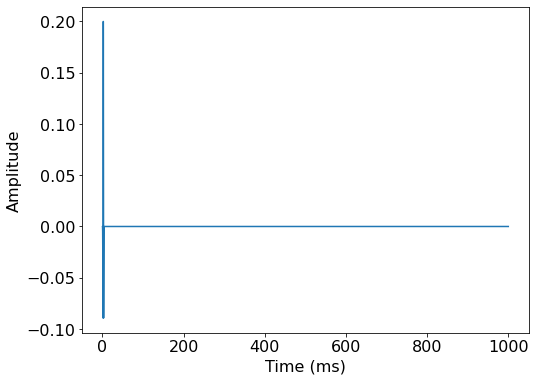

In [6]:
t0, tn = 0., 1000.  #in ms
dt = 0.02            # in ms
time_range = TimeAxis(start=t0, stop=tn, step=dt)

src = RickerSource(name='src', grid=model.grid, f0=0.5, time_range=time_range,a=0.2)
src.coordinates.data[:] = [500., 20.]
src.show()

# The source injection term
src_xx = src.inject(field=tau.forward[0, 0], expr=src)
src_zz = src.inject(field=tau.forward[1, 1], expr=src)

# The receiver
nrec = 101
rec1 = Receiver(name="rec", grid=model.grid, npoint=nrec, time_range=time_range)
rec1.coordinates.data[:, 0] = np.linspace(0., model.domain_size[0], num=nrec)
rec1.coordinates.data[:, -1] = 20

rec2 = Receiver(name="rec2", grid=model.grid, npoint=nrec, time_range=time_range)
rec2.coordinates.data[:, 0] = np.linspace(0., model.domain_size[0], num=nrec)
rec2.coordinates.data[:, -1] = 0

rec3 = Receiver(name="rec3", grid=model.grid, npoint=nrec, time_range=time_range)
rec3.coordinates.data[:, 0] = np.linspace(0., model.domain_size[0], num=nrec)
rec3.coordinates.data[:, -1] = 0

# initializing the rec_term 
rec_term = rec1.interpolate(expr=tau[0, 0] + tau[1, 1])
rec_term += rec2.interpolate(expr=v[1])
rec_term += rec3.interpolate(expr=v[0])

In [7]:
# Damping parameterisation
d_l = (1-0.1*x)**2  # Left side
d_r = (1-0.1*(model.grid.shape[0]-1-x))**2  # Right side
d_b = (1-0.1*(model.grid.shape[1]-1-z))**2  # Base edge

In [8]:
# Now let's try and create the staggered updates
# Lame parameters
l, mu, ro = model.lam, model.mu, model.b

from devito import Eq, grad, div

# fdelmodc reference implementation
eq_v = Eq(v.forward, model.damp * (v + s*ro*div(tau)),subdomain=model.grid.subdomains['main'])
eq_t = Eq(tau.forward,  model.damp *  (tau + s * (l * diag(div(v.forward)) +
                                                mu * (grad(v.forward) + grad(v.forward).T))),subdomain=model.grid.subdomains['main'])



In [9]:
vel=3

In [10]:
((l*diag(div(v.forward)))+mu*(grad(v.forward)+grad(v.forward).T))

Tensor( (Derivative(v_x(t + dt, x + h_x/2, y), x) + Derivative(v_y(t + dt, x, y + h_y/2), y))*lam(x, y) + 2*mu(x, y)*Derivative(v_x(t + dt, x + h_x/2, y), x), (Derivative(v_x(t + dt, x + h_x/2, y), y) + Derivative(v_y(t + dt, x, y + h_y/2), x))*mu(x, y), (Derivative(v_x(t + dt, x + h_x/2, y), y) + Derivative(v_y(t + dt, x, y + h_y/2), x))*mu(x, y), (Derivative(v_x(t + dt, x + h_x/2, y), x) + Derivative(v_y(t + dt, x, y + h_y/2), y))*lam(x, y) + 2*mu(x, y)*Derivative(v_y(t + dt, x, y + h_y/2), y),)

In [11]:
gamma = 0.0002

# Left side

eq_v_damp_left = Eq(v.forward,(1-d_l)*v+dt*div(tau)*model.b,
                    subdomain=model.grid.subdomains['left'])

eq_t_damp_left = Eq(tau.forward,
                    (1-gamma*vel**2*dt-d_l*dt)*tau
                    - dt*((l*diag(div(v.forward)))+mu*(grad(v.forward)+grad(v.forward).T)),
                    subdomain=model.grid.subdomains['left'])

# Right side
eq_v_damp_right = Eq(v.forward,
                     (1-d_r)*v - dt*div(tau)*model.b,
                     subdomain=model.grid.subdomains['right'])

eq_t_damp_right = Eq(tau.forward,
                     (1-gamma*vel**2*dt-d_r*dt)*tau
                     - dt*((l*diag(div(v.forward)))+mu*(grad(v.forward)+grad(v.forward).T)),
                     subdomain=model.grid.subdomains['right'])

# Base edge
eq_v_damp_base = Eq(v.forward,
                    (1-d_b)*v - dt*div(tau)*model.b,
                    subdomain=model.grid.subdomains['base'])

eq_t_damp_base = Eq(tau.forward,
                    (1-gamma*vel**2*dt-d_b*dt)*tau
                    - dt*((l*diag(div(v.forward)))+mu*(grad(v.forward)+grad(v.forward).T)),
                    subdomain=model.grid.subdomains['base'])

In [12]:
def freesurface_top(t_func, v_func):
    time = t_func.grid.stepping_dim
    pos = int(max(t_func.space_order, v_func.space_order)/2)
    
    bc_t_z = [Eq(tau[1,1][time+1, x, pos], 0.)]
    bc_t_xz = [Eq(tau[0,1][time+1, x, i], -tau[0,1][time+1, x, 2*pos-i]) for i in range(pos)]
    bc_t_zx = [Eq(tau[1,0][time+1, x, i], -tau[1,0][time+1, x, 2*pos-i]) for i in range(pos)]
    bc_v = [Eq(v[1][time+1, x, i], -v[1][time+1, x, 2*pos-i]) for i in range(pos)]
    
    return bc_v + bc_t_z+bc_t_xz+bc_t_zx

bc = freesurface_top(tau, v)

In [13]:
from devito import Operator

op = Operator([eq_v, eq_v_damp_left, eq_v_damp_base, eq_v_damp_right,
               eq_t, eq_t_damp_left, eq_t_damp_base, eq_t_damp_right,
               ]
               + src_xx+src_zz + bc+rec_term)

op(time=time_range.num-1)

Operator `Kernel` run in 2.71 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=2.526283000000815, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.0033800000000001234, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=0.016690999999996035, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section3', rank=None),
                     PerfEntry(time=0.05510800000003144, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section4', rank=None),
                     PerfEntry(time=0.045710000000024835, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section5', rank=None),
                     PerfEntry(time=0.04581100000002482, gflopss=0.0, 

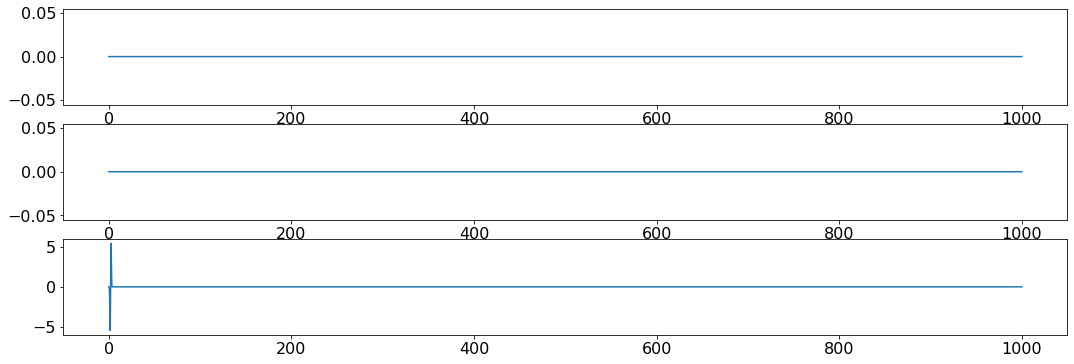

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18,6))

t=np.linspace(0,1000,50001)# the timerange couldn't be used so created this

plt.subplot(3,1,1)
plt.plot(t,rec1.data[:,5])# avoiding boundaries, just left

plt.subplot(3,1,2)
plt.plot(t,rec1.data[:,25])

plt.subplot(3,1,3)
plt.plot(t,rec1.data[:,50])


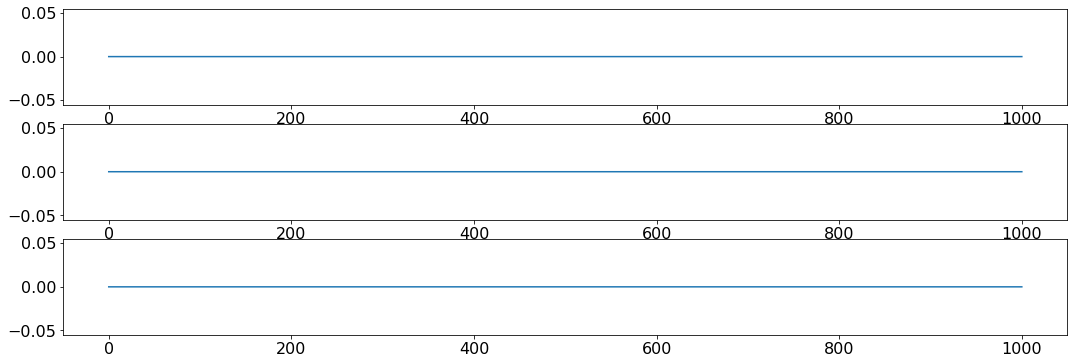

In [15]:
# checking the nearby receivers

plt.figure(figsize=(18,6))

t=np.linspace(0,1000,50001)# the timerange couldn't be used so created this

plt.subplot(3,1,1)
plt.plot(t,rec1.data[:,45])# avoiding boundaries, just left

plt.subplot(3,1,2)
plt.plot(t,rec1.data[:,47])

plt.subplot(3,1,3)
plt.plot(t,rec1.data[:,49])

Checking for the possibility of detection we have that the least count of the accelerometer for +-2g mode is 0.061mg, so we can easily detect some change for these accelerometers.

Some observations: 

1. The magnitude difference between the 50th( the receiver at the location of source) and the 49th reciever is significant(differe by an order of magnitude), at this rate of attenuation it is quite difficult to anticipate reading in our range after a few receivers.

2. The second peak which was being observed when recievers were at the surface is not so prominent when receivers are placed slightly below the surface.

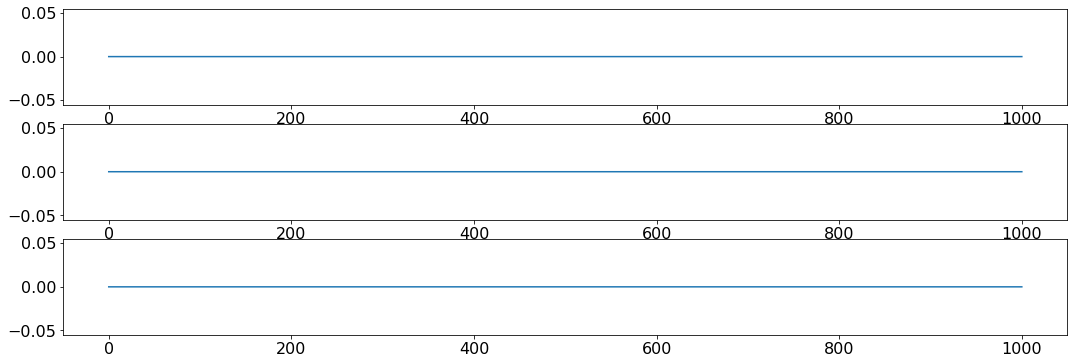

In [16]:

plt.figure(figsize=(18,6))

t=np.linspace(0,1000,50001)# the timerange couldn't be used so created this

plt.subplot(3,1,1)
plt.plot(t,rec2.data[:,45])# avoiding boundaries, just left

plt.subplot(3,1,2)
plt.plot(t,rec2.data[:,47])

plt.subplot(3,1,3)
plt.plot(t,rec2.data[:,49])

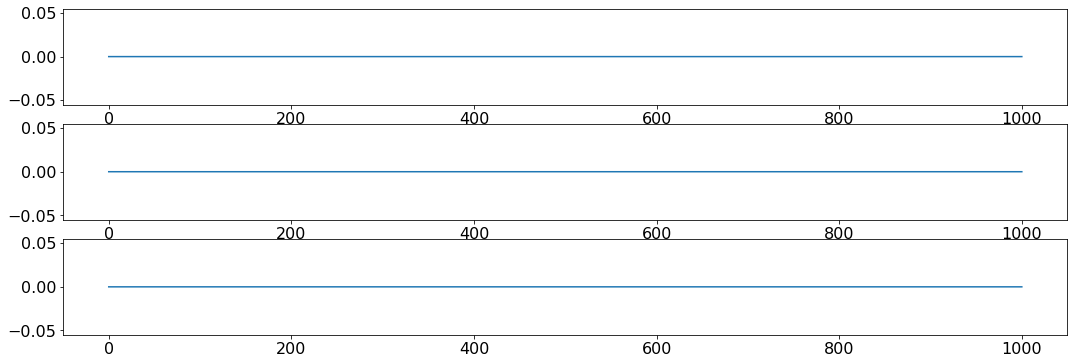

In [17]:
#plotting the data for velcoity receivers in
plt.figure(figsize=(18,6))

t=np.linspace(0,1000,50001)# the timerange couldn't be used so created this

plt.subplot(3,1,1)
plt.plot(t,rec3.data[:,45])# avoiding boundaries, just left

plt.subplot(3,1,2)
plt.plot(t,rec3.data[:,47])

plt.subplot(3,1,3)
plt.plot(t,rec3.data[:,50])

So we see that essentially the reading for all velocity receivers and stress receivers(except the middle one is zero).